In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.collab import *
from fastai.tabular.all import *

# Objetivo:
Este artigo tem como objetivo trabalhar em dados tabulares, com o fim de criar um modelo de filtro colaborativo. Esses filtros são usados amplamente hoje em dia para criar sistemas de recomendação de diversos produtos, neste trabalho, usaremos o dataset [Steam Video Games](https://www.kaggle.com/datasets/tamber/steam-video-games).

---

### Manipulando o dataset:
O dataset oferece quatro colunas principais: 
- user, os usuários;
- game, os títulos do jogos;
- behavior, que mostra se a linha do dataset corresponde ao ato da compra ou de jogar do usuário;
- e hours, que mostra o número de horas jogadas pelo usuário, ou apenas como 1.0 caso o behavior tenha sido a compra.

No dataset usado, não há uma maneira imediata de criar um sistema de rating para ser usado pelo modelo de filtro colaborativo. Então, usaremos o *ln* do número de horas jogados por todos os jogadores, para cada jogo, assim como a média de horas jogadas para cada jogo, para criar um sistema de notas, em que, mede a nota provável que um jogador daria baseado na distância do seu número de horas jogadas pela média de horas jogadas do jogo específico, sendo que se o jogador tem o mesmo tanto de horas jogadas do que a média, a nota seria um 3 (baseado em especulação).

Faço isso por separar o dataset em dois: plays e purchases, sendo o primeiro apenas as linhas do dataset que contenham o behavior "play", mostrando as horas que o usuário gastou jogando o jogo. O segundo contém apenas as linhas com o behavior "purchase", que mostra os jogos comprados pelo usuário.

In [2]:
df = pd.read_csv('../input/steam-video-games/steam-200k.csv', names = ['user', 'game', 'behavior', 'hours', 'zero'])
print(df.info(), "\n\n", df.head(), "\n\n", df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user      200000 non-null  int64  
 1   game      200000 non-null  object 
 2   behavior  200000 non-null  object 
 3   hours     200000 non-null  float64
 4   zero      200000 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.6+ MB
None 

         user                        game  behavior  hours  zero
0  151603712  The Elder Scrolls V Skyrim  purchase    1.0     0
1  151603712  The Elder Scrolls V Skyrim      play  273.0     0
2  151603712                   Fallout 4  purchase    1.0     0
3  151603712                   Fallout 4      play   87.0     0
4  151603712                       Spore  purchase    1.0     0 

                user          hours      zero
count  2.000000e+05  200000.000000  200000.0
mean   1.036559e+08      17.874384       0.0
std    7.208074e+0

In [3]:
plays = df.where(df.behavior == 'play')
plays.dropna(inplace = True)
plays.reset_index(drop = True, inplace = True)
purchases = df.where(df.behavior == 'purchase')
purchases.dropna(inplace = True)
purchases.reset_index(drop = True, inplace = True)

In [4]:
plays, purchases

(              user                        game behavior  hours  zero
 0      151603712.0  The Elder Scrolls V Skyrim     play  273.0   0.0
 1      151603712.0                   Fallout 4     play   87.0   0.0
 2      151603712.0                       Spore     play   14.9   0.0
 3      151603712.0           Fallout New Vegas     play   12.1   0.0
 4      151603712.0               Left 4 Dead 2     play    8.9   0.0
 ...            ...                         ...      ...    ...   ...
 70484  128470551.0                Fallen Earth     play    2.4   0.0
 70485  128470551.0                 Magic Duels     play    2.2   0.0
 70486  128470551.0                 Titan Souls     play    1.5   0.0
 70487  128470551.0  Grand Theft Auto Vice City     play    1.5   0.0
 70488  128470551.0                        RUSH     play    1.4   0.0
 
 [70489 rows x 5 columns],
                user                        game  behavior  hours  zero
 0       151603712.0  The Elder Scrolls V Skyrim  purchase 

In [5]:
plays['log_hours'] = np.log1p(plays.hours)
plays.describe()

,user,hours,zero,log_hours
count,7.048900e+04,70489.000000,70489.0,70489.000000
mean,1.058812e+08,48.878063,0.0,2.052941
std,7.150365e+07,229.335236,0.0,1.615664
min,5.250000e+03,0.100000,0.0,0.095310
25%,4.934256e+07,1.000000,0.0,0.693147
50%,9.169067e+07,4.500000,0.0,1.704748
75%,1.556738e+08,19.100000,0.0,3.000720
max,3.099031e+08,11754.000000,0.0,9.372034


In [6]:
plays

,user,game,behavior,hours,zero,log_hours
0,151603712.0,The Elder Scrolls V Skyrim,play,273.0,0.0,5.613128
1,151603712.0,Fallout 4,play,87.0,0.0,4.477337
2,151603712.0,Spore,play,14.9,0.0,2.766319
3,151603712.0,Fallout New Vegas,play,12.1,0.0,2.572612
4,151603712.0,Left 4 Dead 2,play,8.9,0.0,2.292535
...,...,...,...,...,...,...
70484,128470551.0,Fallen Earth,play,2.4,0.0,1.223775
70485,128470551.0,Magic Duels,play,2.2,0.0,1.163151
70486,128470551.0,Titan Souls,play,1.5,0.0,0.916291
70487,128470551.0,Grand Theft Auto Vice City,play,1.5,0.0,0.916291


In [7]:
hour_mean = plays.groupby('game')['log_hours'].mean()
hour_mean

game
007 Legends                                                   0.530628
0RBITALIS                                                     0.331577
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby)    1.297550
10 Second Ninja                                               1.130882
10,000,000                                                    1.526056
                                                                ...   
rymdkapsel                                                    0.741937
sZone-Online                                                  0.559071
the static speaks my name                                     0.218478
theHunter                                                     0.757919
theHunter Primal                                              2.245773
Name: log_hours, Length: 3600, dtype: float64

In [8]:
hour_mean[plays.game[0]], plays.log_hours[0]/5

(3.58580220624633, 1.122625621277614)

---

Arredondo as notas de forma que se encontram entre 0,5 e 5,0, em passos de 0,5 pontos.

---

In [9]:
rates = []
i = 0
for g in plays.game:
    rate = hour_mean[g] / 3
    rate = plays['log_hours'][i] / rate
    if rate > 4.5:
        rate = 5.0
    elif rate > 4.0:
        rate = 4.5
    elif rate > 3.5:
        rate = 4.0
    elif rate > 3.0:
        rate = 3.5
    elif rate > 2.5:
        rate = 3.0
    elif rate > 2.0:
        rate = 2.5
    elif rate > 1.5:
        rate = 2.0
    elif rate > 1.0:
        rate = 1.5
    elif rate > 0.5:
        rate = 1.0
    elif rate > 0.0:
        rate = 0.5
    else: rate = 0.0
    rates.append(rate)
    i += 1
    
plays['rate'] = rates
plays.describe()

,user,hours,zero,log_hours,rate
count,7.048900e+04,70489.000000,70489.0,70489.000000,70489.000000
mean,1.058812e+08,48.878063,0.0,2.052941,2.976784
std,7.150365e+07,229.335236,0.0,1.615664,1.520216
min,5.250000e+03,0.100000,0.0,0.095310,0.500000
25%,4.934256e+07,1.000000,0.0,0.693147,1.500000
50%,9.169067e+07,4.500000,0.0,1.704748,3.000000
75%,1.556738e+08,19.100000,0.0,3.000720,4.500000
max,3.099031e+08,11754.000000,0.0,9.372034,5.000000


In [10]:
plays.drop('log_hours', axis = 1, inplace = True)

---

No dataset, há jogos que foram comprados pelos usuários mas nunca jogados, se tratarmos as notas dos jogos baseado apenas nas horas jogadas, estaríamos desperdiçando milhares de dados, então, caso o usuário tenha apenas comprado o jogo, contaremos com que ele tenha dado a nota pro jogo como um 2,5 automático, já que não compraria um jogo que não lhe interessasse.

Arrumo o dataset, por dar um merge utilizando apenas os valores fora da interseção dos datasets, plays e purchases.

---

In [11]:
purchases['rate'] = 2.5
purchases.describe()

,user,hours,zero,rate
count,1.295110e+05,129511.0,129511.0,129511.0
mean,1.024447e+08,1.0,0.0,2.5
std,7.236442e+07,0.0,0.0,0.0
min,5.250000e+03,1.0,0.0,2.5
25%,4.550738e+07,1.0,0.0,2.5
50%,8.605570e+07,1.0,0.0,2.5
75%,1.542307e+08,1.0,0.0,2.5
max,3.099031e+08,1.0,0.0,2.5


In [12]:
purchases, plays

(               user                        game  behavior  hours  zero  rate
 0       151603712.0  The Elder Scrolls V Skyrim  purchase    1.0   0.0   2.5
 1       151603712.0                   Fallout 4  purchase    1.0   0.0   2.5
 2       151603712.0                       Spore  purchase    1.0   0.0   2.5
 3       151603712.0           Fallout New Vegas  purchase    1.0   0.0   2.5
 4       151603712.0               Left 4 Dead 2  purchase    1.0   0.0   2.5
 ...             ...                         ...       ...    ...   ...   ...
 129506  128470551.0                Fallen Earth  purchase    1.0   0.0   2.5
 129507  128470551.0                 Magic Duels  purchase    1.0   0.0   2.5
 129508  128470551.0                 Titan Souls  purchase    1.0   0.0   2.5
 129509  128470551.0  Grand Theft Auto Vice City  purchase    1.0   0.0   2.5
 129510  128470551.0                        RUSH  purchase    1.0   0.0   2.5
 
 [129511 rows x 6 columns],
               user               

In [13]:
aux = plays.merge(purchases, how='outer', on=['user','game'])
aux

,user,game,behavior_x,hours_x,zero_x,rate_x,behavior_y,hours_y,zero_y,rate_y
0,151603712.0,The Elder Scrolls V Skyrim,play,273.0,0.0,5.0,purchase,1.0,0.0,2.5
1,151603712.0,Fallout 4,play,87.0,0.0,4.0,purchase,1.0,0.0,2.5
2,151603712.0,Spore,play,14.9,0.0,4.0,purchase,1.0,0.0,2.5
3,151603712.0,Fallout New Vegas,play,12.1,0.0,3.0,purchase,1.0,0.0,2.5
4,151603712.0,Left 4 Dead 2,play,8.9,0.0,3.0,purchase,1.0,0.0,2.5
...,...,...,...,...,...,...,...,...,...,...
129530,99096740.0,The Elder Scrolls V Skyrim - Hearthfire,NaN,NaN,NaN,NaN,purchase,1.0,0.0,2.5
129531,176449171.0,Counter-Strike,NaN,NaN,NaN,NaN,purchase,1.0,0.0,2.5
129532,176449171.0,Counter-Strike Condition Zero,NaN,NaN,NaN,NaN,purchase,1.0,0.0,2.5
129533,176449171.0,Counter-Strike Condition Zero Deleted Scenes,NaN,NaN,NaN,NaN,purchase,1.0,0.0,2.5


In [14]:
len(purchases.game.unique()), len(plays.game.unique()), len(aux.game.unique())

(5155, 3600, 5155)

---

Após juntar os dois datasets em um, descarto as colunas desnecessárias, mantendo apenas as colunas **"user"**, **"game"** e a recentemente criada **"rate"**.

---

In [15]:
aux.rename(columns={'rate_x' : 'rate'}, inplace = True)
aux.drop(['behavior_x', 'zero_x', 'hours_x', 'behavior_y', 'hours_y', 'zero_y', 'rate_y'], axis = 1, inplace = True)
rates = {"rate" : 2.5}
aux.fillna(rates, inplace=True)

In [16]:
test = 'Counter-Strike'
plays.query('game == @test'), purchases.query('game == @test')

(             user            game behavior   hours  zero  rate
 339    30695285.0  Counter-Strike     play     0.2   0.0   0.5
 342    48845802.0  Counter-Strike     play   211.0   0.0   5.0
 364    62923086.0  Counter-Strike     play    91.0   0.0   5.0
 649    54103616.0  Counter-Strike     play  1008.0   0.0   5.0
 688    38763767.0  Counter-Strike     play     0.8   0.0   1.0
 ...           ...             ...      ...     ...   ...   ...
 69257  33362395.0  Counter-Strike     play  1445.0   0.0   5.0
 69373  53784377.0  Counter-Strike     play   848.0   0.0   5.0
 69464  25411448.0  Counter-Strike     play    20.0   0.0   3.5
 69939   7519923.0  Counter-Strike     play    35.0   0.0   4.0
 70119  65729155.0  Counter-Strike     play    25.0   0.0   3.5
 
 [568 rows x 6 columns],
                user            game  behavior  hours  zero  rate
 757      30695285.0  Counter-Strike  purchase    1.0   0.0   2.5
 764      48845802.0  Counter-Strike  purchase    1.0   0.0   2.5
 794   

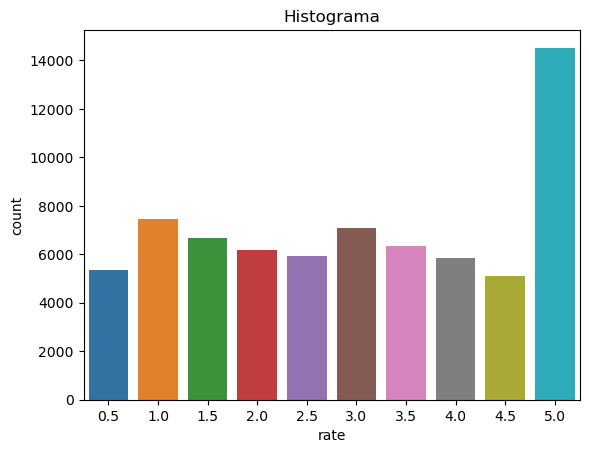

In [17]:
import seaborn as sns
sns.countplot(data=plays, x="rate").set(title="Histograma");

In [18]:
plays = aux.copy()

In [19]:
#plays = plays.append(purchases)
#plays.reset_index(drop = True, inplace = True)
plays

,user,game,rate
0,151603712.0,The Elder Scrolls V Skyrim,5.0
1,151603712.0,Fallout 4,4.0
2,151603712.0,Spore,4.0
3,151603712.0,Fallout New Vegas,3.0
4,151603712.0,Left 4 Dead 2,3.0
...,...,...,...
129530,99096740.0,The Elder Scrolls V Skyrim - Hearthfire,2.5
129531,176449171.0,Counter-Strike,2.5
129532,176449171.0,Counter-Strike Condition Zero,2.5
129533,176449171.0,Counter-Strike Condition Zero Deleted Scenes,2.5


In [20]:
plays.user.unique()[:5], plays.game.unique()[:5]

(array([1.51603712e+08, 1.87131847e+08, 5.99457010e+07, 5.38751280e+07,
        1.40954425e+08]),
 array(['The Elder Scrolls V Skyrim', 'Fallout 4', 'Spore',
        'Fallout New Vegas', 'Left 4 Dead 2'], dtype=object))

In [21]:
pd.crosstab(plays.user[:280], plays.game.unique()[:280], values=plays.rate, aggfunc='mean')

col_0,404Sight,7 Days to Die,A Virus Named TOM,APB Reloaded,ARK Survival Evolved,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome,Afterlife Empire,Age of Empires II HD Edition,Air Brawl,Alien Swarm,...,Ultra Street Fighter IV,Undertale,Unepic,Unturned,Valkyria Chronicles,WRC 4 FIA WORLD RALLY CHAMPIONSHIP,War Thunder,Watch_Dogs,Wolfenstein The New Order,Ziggurat
user,,,,,,,,,,,,,,,,,,,,,
26122540.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
53875128.0,3.5,NaN,NaN,NaN,0.5,1.0,1.0,3.5,2.0,0.5,...,NaN,NaN,1.5,0.5,1.5,0.5,NaN,5.0,5.0,3.0
59945701.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63024728.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76933274.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126340495.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140954425.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150128162.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151603712.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
plays.query('user == 53875128.0')

,user,game,rate
49,53875128.0,Grand Theft Auto V,4.0
50,53875128.0,Insurgency,5.0
51,53875128.0,Left 4 Dead 2,5.0
52,53875128.0,METAL GEAR SOLID V THE PHANTOM PAIN,3.5
53,53875128.0,S.T.A.L.K.E.R. Shadow of Chernobyl,5.0
...,...,...,...
71123,53875128.0,Whisper of a Rose,2.5
71124,53875128.0,Wizorb,2.5
71125,53875128.0,Wrack,2.5
71126,53875128.0,Ys Origin,2.5


In [23]:
mvps = plays.user.value_counts() #0, 2, 3
plays.query('user == @mvps.index[0]')[:10]

,user,game,rate
43027,62990992.0,Counter-Strike Global Offensive,5.0
43028,62990992.0,Sid Meier's Civilization V,5.0
43029,62990992.0,Total War SHOGUN 2,5.0
43030,62990992.0,Total War ROME II - Emperor Edition,4.5
43031,62990992.0,Dungeon Defenders,5.0
43032,62990992.0,Age of Empires Online,4.5
43033,62990992.0,XCOM Enemy Unknown,5.0
43034,62990992.0,Empire Total War,4.5
43035,62990992.0,Might & Magic Heroes VI,4.5
43036,62990992.0,Assassin's Creed IV Black Flag,4.5


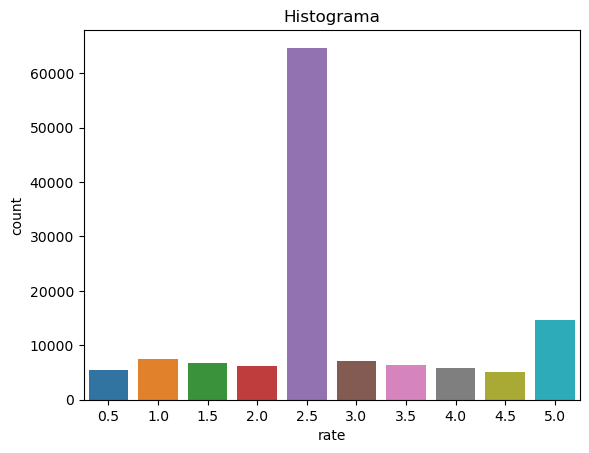

In [24]:
sns.countplot(data=plays, x="rate").set(title="Histograma");

In [25]:
plays

,user,game,rate
0,151603712.0,The Elder Scrolls V Skyrim,5.0
1,151603712.0,Fallout 4,4.0
2,151603712.0,Spore,4.0
3,151603712.0,Fallout New Vegas,3.0
4,151603712.0,Left 4 Dead 2,3.0
...,...,...,...
129530,99096740.0,The Elder Scrolls V Skyrim - Hearthfire,2.5
129531,176449171.0,Counter-Strike,2.5
129532,176449171.0,Counter-Strike Condition Zero,2.5
129533,176449171.0,Counter-Strike Condition Zero Deleted Scenes,2.5


---

## CollabDataLoaders
Pega os dados que serão carregados no modelo e os organiza de forma alfabética e crescente em classes. Também adiciona um dado extra, que é o NaN.

---

## Fatores Latentes
Fatores latentes são características especiais sobre os itens e usuários analisados, que o modelo de collaborative filtering aprenderá, baseando-se nas notas dos itens e nas características/similaridades dos usuários ao avaliar um item em comum.
Os fatores latentes, ambos dos itens e dos usuários, podem ser unidos por meio de um produto escalar, para preencher o crosstab anterior com notas que antes lá não continham.

---

## One Hot Encoding & Embedding
### One Hot Encoding
One Hot significa que apenas um valor está "ativado", one hot encoding é usado para separar dados categóricos, numa maneira de checar apenas o dado que se tem interesse.
### Embedding
Significa, basicamente, buscar valores numa matriz.
Um mapeamento de um conjunto discreto (neste caso, o conjunto de consultas ou o conjunto de itens a serem recomendados) para um espaço vetorial chamado de espaço de embedding. Muitos sistemas de recomendação dependem do aprendizado de uma representação de embedding apropriada das consultas e itens. - [Tirado do Google Developers](https://developers.google.com/machine-learning/recommendation/overview/terminology?hl=pt-br).

---

In [26]:
dls = CollabDataLoaders.from_df(plays, item_name = 'game', rating_name = 'rate', bs=64)
dls.show_batch()

,user,game,rate
0,18149166.0,X-COM Apocalypse,2.5
1,232048976.0,Dota 2,5.0
2,176771888.0,Neverwinter,2.5
3,109175936.0,Arma 3,1.5
4,157095472.0,Rising Storm/Red Orchestra 2 Multiplayer,2.5
5,73946536.0,Alien Swarm,2.0
6,55906572.0,Magicka Wizard Wars,2.5
7,51557404.0,Still Life,2.5
8,30246420.0,Metro 2033,3.0
9,70408904.0,GRID 2,2.5


In [27]:
n_users  = len(dls.classes['user'])
n_games = len(dls.classes['game'])
n_factors = 7

user_factors = torch.randn(n_users, n_factors)
game_factors = torch.randn(n_games, n_factors)

In [28]:
n_users, n_games

(11144, 5156)

In [29]:
one_hot_3 = one_hot(3, n_users).float()
(user_factors.t() @ one_hot_3, user_factors[3])

(tensor([-1.3802, -0.4711,  1.5413,  0.0300, -2.5913,  1.2278, -0.7939]),
 tensor([-1.3802, -0.4711,  1.5413,  0.0300, -2.5913,  1.2278, -0.7939]))

In [30]:
class DotProductBias(Module):
    def __init__(self, n_users, n_games, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.game_factors = Embedding(n_games, n_factors)
        self.game_bias = Embedding(n_games, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        games = self.game_factors(x[:,1])
        res = (users * games).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.game_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [31]:
model = DotProductBias(n_users, n_games, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.293172,1.259847,00:14
1,1.056834,1.326975,00:13
2,0.603729,1.430238,00:13
3,0.281884,1.476757,00:13
4,0.164657,1.486163,00:13


In [32]:
x, y = dls.one_batch()
x.shape

torch.Size([64, 2])

---

## Weight Decay
Weight Decay consiste em somar à sua função loss a soma de todos os pesos ao quadrado. A ideia é criar modelos com pesos de valores baixos, porque, assim como no gráfico abaixo, quão maior os pesos são (no gráfico, quão maior _"a"_ é) mais a função terá a tendência em se moldar aos dados (overfitting). Assim, o modelo perderá um pouco a sua capacidade de treino, mas será gerado um modelo mais capaz em generalizar a partir dos dados.

---

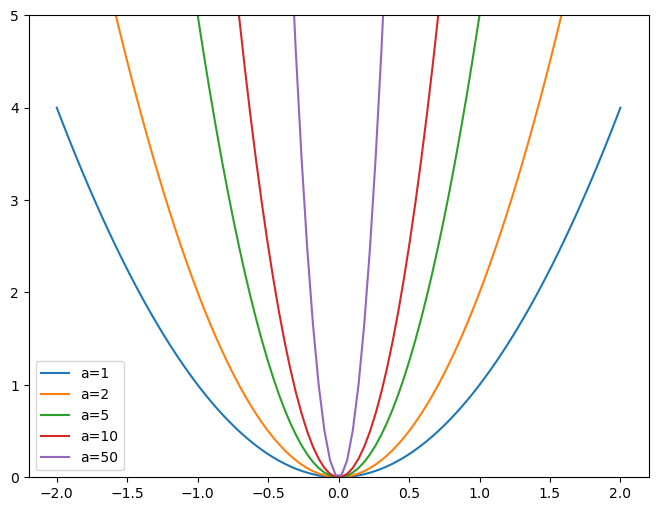

In [33]:
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

In [34]:
model = DotProductBias(n_users, n_games, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.237955,1.258250,00:13
1,1.138139,1.259185,00:13
2,0.899424,1.281772,00:13
3,0.613901,1.291801,00:13
4,0.428072,1.296676,00:13


In [35]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[ 0.2637],
        [-0.0112],
        [-0.0441]], requires_grad=True)]

In [36]:
type(t.a.weight)

torch.nn.parameter.Parameter

In [37]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

---

## Bias
Bias ou viés, é uma única linha de dados que medirá a tendência de cada usuário ou item nas suas notas. Um usuário pode sempre dar notas baixas ou altas, independente do item sendo analizado. Assim como um item pode receber apenas notas baixas, ou apenas notas altas, independente de quem está avaliando.

---

In [38]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.game_factors = create_params([n_games, n_factors])
        self.game_bias = create_params([n_games])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        games = self.game_factors[x[:,1]]
        res = (users*games).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.game_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [39]:
model = DotProductBias(n_users, n_games, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.253460,1.261853,00:14
1,1.133495,1.259391,00:13
2,0.858058,1.282714,00:13
3,0.602691,1.292064,00:13
4,0.440703,1.296621,00:13


In [40]:
game_bias = learn.model.game_bias.squeeze()
idxs = game_bias.argsort()[:5]
[dls.classes['game'][i] for i in idxs]

['Zombie Panic Source',
 'Crusaders of the Lost Idols',
 'Endless Sky',
 "Wasteland 2 Director's Cut",
 'Steel Ocean']

In [41]:
idxs = game_bias.argsort(descending=True)[:5]
[dls.classes['game'][i] for i in idxs]

['The Walking Dead',
 'Counter-Strike Global Offensive',
 'METAL GEAR SOLID V THE PHANTOM PAIN',
 'The Sims(TM) 3',
 'Grand Theft Auto V']

---

## Interpretando os fatores
O gráfico abaixo representa onde os diversos jogos seriam colocados em uma tabela, baseado em componentes principais importantes. Cada grupo de jogos localizados perto um do outro no gráfico, teria um conjunto de características em comum.

---

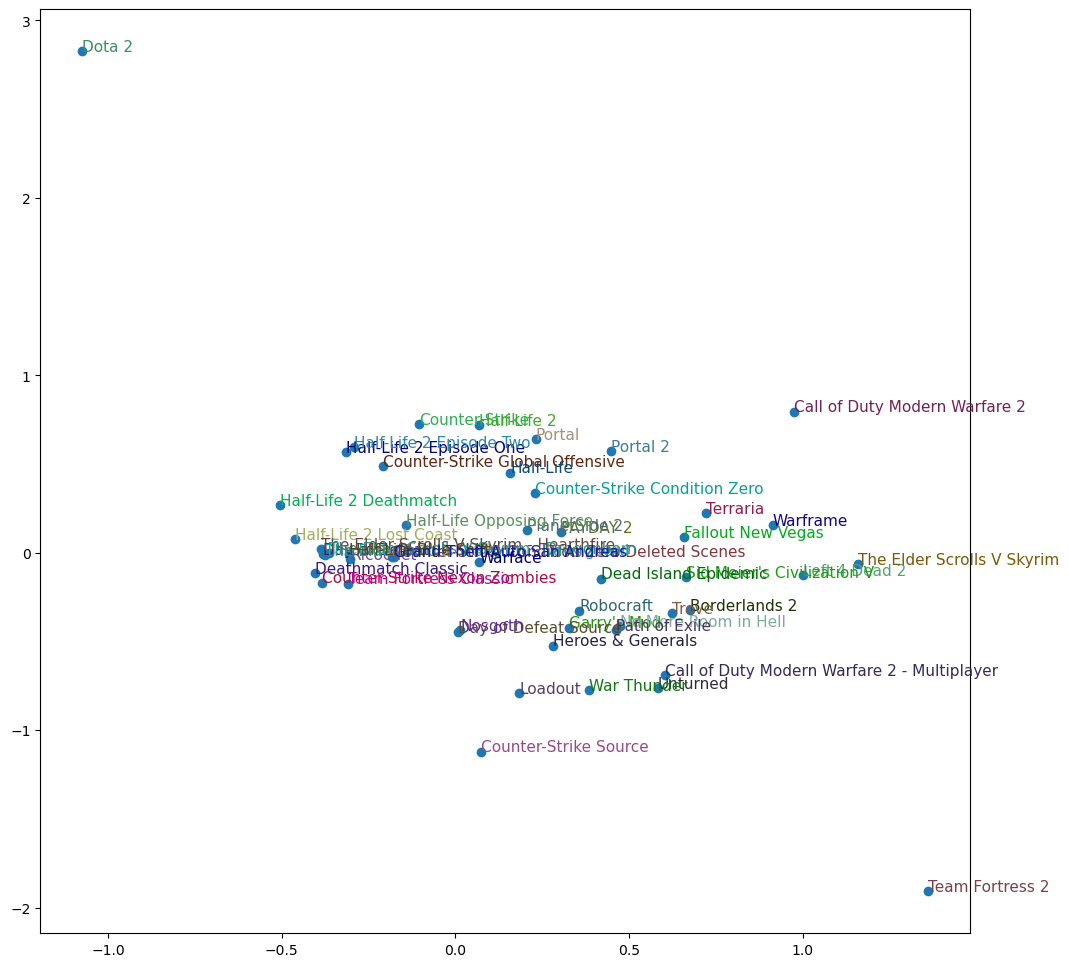

In [42]:
g = plays.groupby('game')['rate'].count()
top_games = g.sort_values(ascending=False).index.values[:2000]
top_idxs = tensor([learn.dls.classes['game'].o2i[m] for m in top_games])
game_w = learn.model.game_factors[top_idxs].cpu().detach()
game_pca = game_w.pca(3)
fac0,fac1,fac2 = game_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_games[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

In [59]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [60]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.256819,1.262250,00:15
1,1.108412,1.258549,00:14
2,0.858692,1.283884,00:15
3,0.587625,1.295659,00:15
4,0.428641,1.300735,00:15


In [45]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(11144, 50)
  (i_weight): Embedding(5156, 50)
  (u_bias): Embedding(11144, 1)
  (i_bias): Embedding(5156, 1)
)

In [61]:
game_bias = learn.model.i_bias.weight.squeeze()
idxs = game_bias.argsort(descending=True)[:5]
[dls.classes['game'][i] for i in idxs]

['Counter-Strike Global Offensive',
 'The Walking Dead',
 'Grand Theft Auto V',
 'South Park The Stick of Truth',
 'The Sims(TM) 3']

In [65]:
game_factors = learn.model.i_weight.weight
idx = dls.classes['game'].o2i['The Walking Dead']
distances = nn.CosineSimilarity(dim=1)(game_factors, game_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['game'][idx]

'Rock of Ages'

<img src="https://cdn.cloudflare.steamstatic.com/steam/apps/207610/ss_b8880868558943bf6b8e1aa94fe9ab51ea04472a.1920x1080.jpg?t=1681496660"  width="600" height="300">
<img src="https://images.gamewatcherstatic.com/image/file/0/74/27960/0020086.jpg"  width="600" height="300">

In [48]:
embs = get_emb_sz(dls)
embs

[(11144, 295), (5156, 192)]

In [49]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [50]:
model = CollabNN(*embs)

In [51]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,1.235136,1.278895,00:34
1,1.196227,1.254108,00:29
2,1.141515,1.279263,00:29
3,1.005706,1.341118,00:29
4,0.846293,1.394324,00:31


In [52]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.5)

epoch,train_loss,valid_loss,time
0,1.286084,1.283737,00:36
1,1.249298,1.275206,00:36
2,1.248733,1.266796,00:36
3,1.215265,1.262595,00:39
4,1.101687,1.309675,00:36


---

Disponível no huggingface em: https://huggingface.co/spaces/matheusfga/lesson_7

In [54]:
okay = dls.classes['user'][100]
plays.query('user == @okay')

,user,game,rate
100128,5314150.0,Counter-Strike,2.5
100129,5314150.0,Counter-Strike Condition Zero,2.5
100130,5314150.0,Counter-Strike Condition Zero Deleted Scenes,2.5
100131,5314150.0,Counter-Strike Source,2.5
100132,5314150.0,Day of Defeat Source,2.5
100133,5314150.0,Half-Life 2 Deathmatch,2.5
100134,5314150.0,Half-Life 2 Lost Coast,2.5


In [55]:
learn.embeds[0]

Embedding(11144, 295)

In [56]:
g = plays.groupby('game')['rate'].count()
top_games = g.sort_values(ascending=False).index.values[:1000]
top_games[:10]

array(['Dota 2', 'Team Fortress 2', 'Unturned',
       'Counter-Strike Global Offensive', 'Half-Life 2 Lost Coast',
       'Counter-Strike Source', 'Left 4 Dead 2', 'Counter-Strike',
       'Warframe', 'Half-Life 2 Deathmatch'], dtype=object)

In [57]:
game_bias = learn.model.bias(top_games, is_item=True)
game_bias.shape

AttributeError: 'EmbeddingNN' object has no attribute 'bias'

In [ ]:
mean_ratings = plays.groupby('game')['rate'].mean()
game_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [ ]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

In [ ]:
learn.model

In [ ]:
dls.one_batch()